### Notebook for `leiden` clustering of 6mpi lymphoids of Pkp2 Ctr noninf

#### Environment: SCCAF

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240320
- **Last modified**: 240325

#### Load required modules

In [1]:
import SCCAF
from SCCAF import SCCAF_assessment, plot_roc
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

-----
anndata     0.10.6
scanpy      1.9.8
-----
PIL                 10.2.0
SCCAF               NA
asttokens           NA
attr                23.2.0
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
igraph              0.11.4
ipykernel           6.29.3
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.42.0
louvain             0.8.2
matplotlib          3.8.3
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.1
numexpr             2.9.0
numpy               1.26.4
packaging           24.0
pandas              2.2.1
parso               0.8.3
patsy               0.5.6
pickleshare         0.7.5
pkg_resources       NA
platformdirs        4.2.0
prompt_toolkit      3.0.42
psutil             

In [3]:
warnings.simplefilter(action = 'ignore')
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

In [5]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

#### Load data set

In [6]:
input = '/home/acirnu/data/ACM_cardiac_leuco/scANVI/ACM_lymphoids_scANVI_general_celltypes_from_HCA_lymphoids_ac240320.raw.h5ad'
adata = sc.read_h5ad(input)
adata

AnnData object with n_obs × n_vars = 10104 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'n_genes', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_coun

Make sure to use raw counts

In [7]:
X_is_raw(adata)

True

In [8]:
#Look at adata.X  -> seems like the data is normalized already!

X_data = adata.X.copy()
X_data_sparse = csr_matrix(X_data)
X_data_df = pd.DataFrame.sparse.from_spmatrix(X_data_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", X_data_df.shape)
print(X_data_df)

Shape of counts DataFrame: (10104, 29378)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACCCAAGATACAGT-1-A1     0       0        0        0    0      0        0   
AACCCAATCAGCTGAT-1-A1     0       0        0        0    0      0        0   
AACCTGAAGATAGCAT-1-A1     0       0        0        0    0      0        0   
AACGTCAAGCTACTGT-1-A1     0       0        0        0    0      0        0   
AACTTCTCAAGCGCTC-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTTGATCAGTATGACA-1-B2     0       0        0        0    0      0        0   
TTTGGAGAGATTAGCA-1-B2     0       0        0        0    0      0        0   
TTTGGTTAGCACCTGC-1-B2     0       0        0        0    0      0        0   
TTTGTTGAGACCTCCG-1-B2     0       0        0        0    0      0        0   
TTTGTTGGTAGTAAGT-1-B2     0       0        0        0    0      0        0   

                     

Save raw counts

In [9]:
adata.raw = adata

### Subset data set to contain only Pkp2 Ctr noninf

In [10]:
adata_Ctr = adata[adata.obs['condition'].isin(['Pkp2_Ctr_noninf'])].copy()
adata_Ctr

AnnData object with n_obs × n_vars = 710 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'n_genes', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'batch', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts

#### Define neighbors after subsetting
After subsetting the neighbor data is also subsetted, however the UMAP representation still uses the info from the whole data set, that's why the neighbors have to be identiefied again

In [11]:
sc.pp.neighbors(adata_Ctr, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


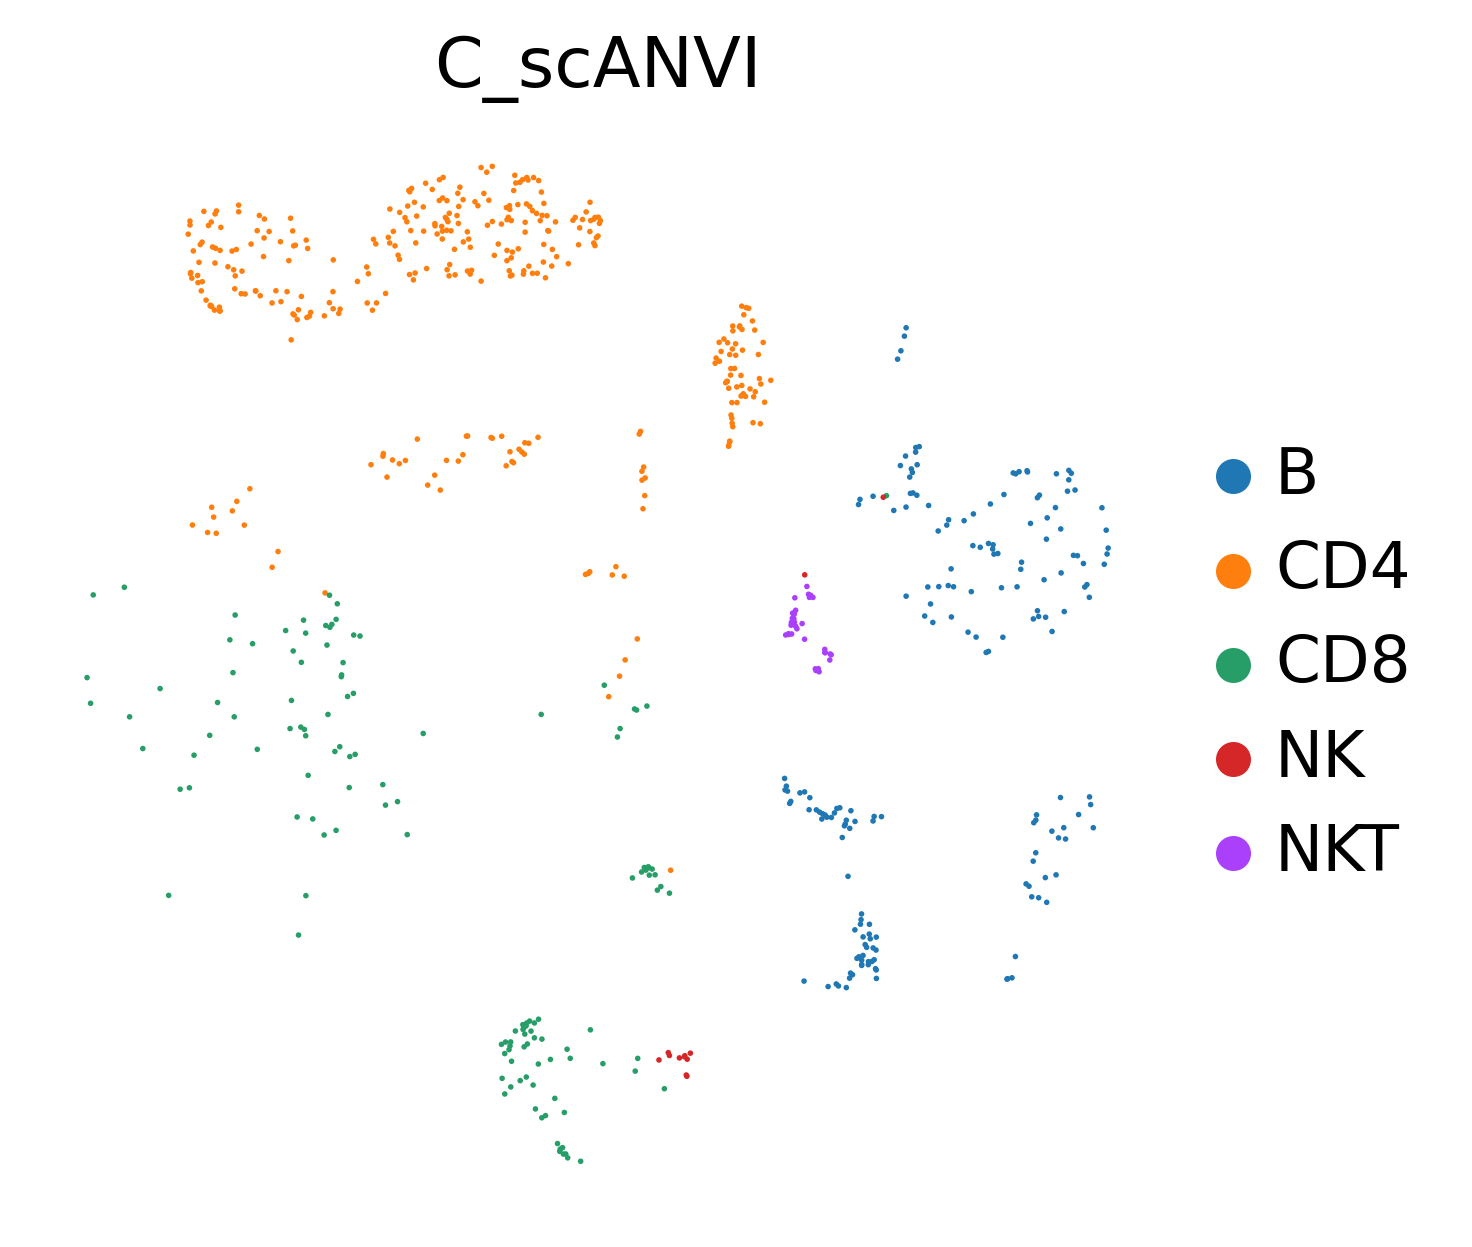

In [12]:
sc.pl.umap(adata_Ctr, color=['C_scANVI'], size = 5, frameon = False)

#### Normalize and log transform data (modify adata.X), raw counts are still stored in adata.raw

In [13]:
sc.pp.normalize_total(adata_Ctr, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_Ctr)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Fabp4', 'Igkc', 'Igha', 'Gm42418', 'Malat1', 'Tmsb4x']
    finished (0:00:00)


In [14]:
X_data = adata_Ctr.X.copy()
X_data_sparse = csr_matrix(X_data)
X_data_df = pd.DataFrame.sparse.from_spmatrix(X_data_sparse, index=adata_Ctr.obs.index, columns=adata_Ctr.var.index)
print("Shape of counts DataFrame:", X_data_df.shape)
print(X_data_df)

Shape of counts DataFrame: (710, 29378)
                       Xkr4  Gm1992  Gm19938  Gm37381  Rp1  Sox17  Gm37587  \
AAACCCAAGATACAGT-1-A1     0       0        0        0    0      0        0   
AACCCAATCAGCTGAT-1-A1     0       0        0        0    0      0        0   
AACCTGAAGATAGCAT-1-A1     0       0        0        0    0      0        0   
AACGTCAAGCTACTGT-1-A1     0       0        0        0    0      0        0   
AACTTCTCAAGCGCTC-1-A1     0       0        0        0    0      0        0   
...                     ...     ...      ...      ...  ...    ...      ...   
TTGTGTTTCTCTTCAA-1-A4     0       0        0        0    0      0        0   
TTTAGTCTCTCGGCTT-1-A4     0       0        0        0    0      0        0   
TTTCACACATGGAACG-1-A4     0       0        0        0    0      0        0   
TTTGGAGCAGTCAACT-1-A4     0       0        0        0    0      0        0   
TTTGGTTAGATTGTGA-1-A4     0       0        0        0    0      0        0   

                       

#### Perform leiden clustering with resolution 0.1 and assess with SCCAF

In [15]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Mean CV accuracy: 0.9691
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9663


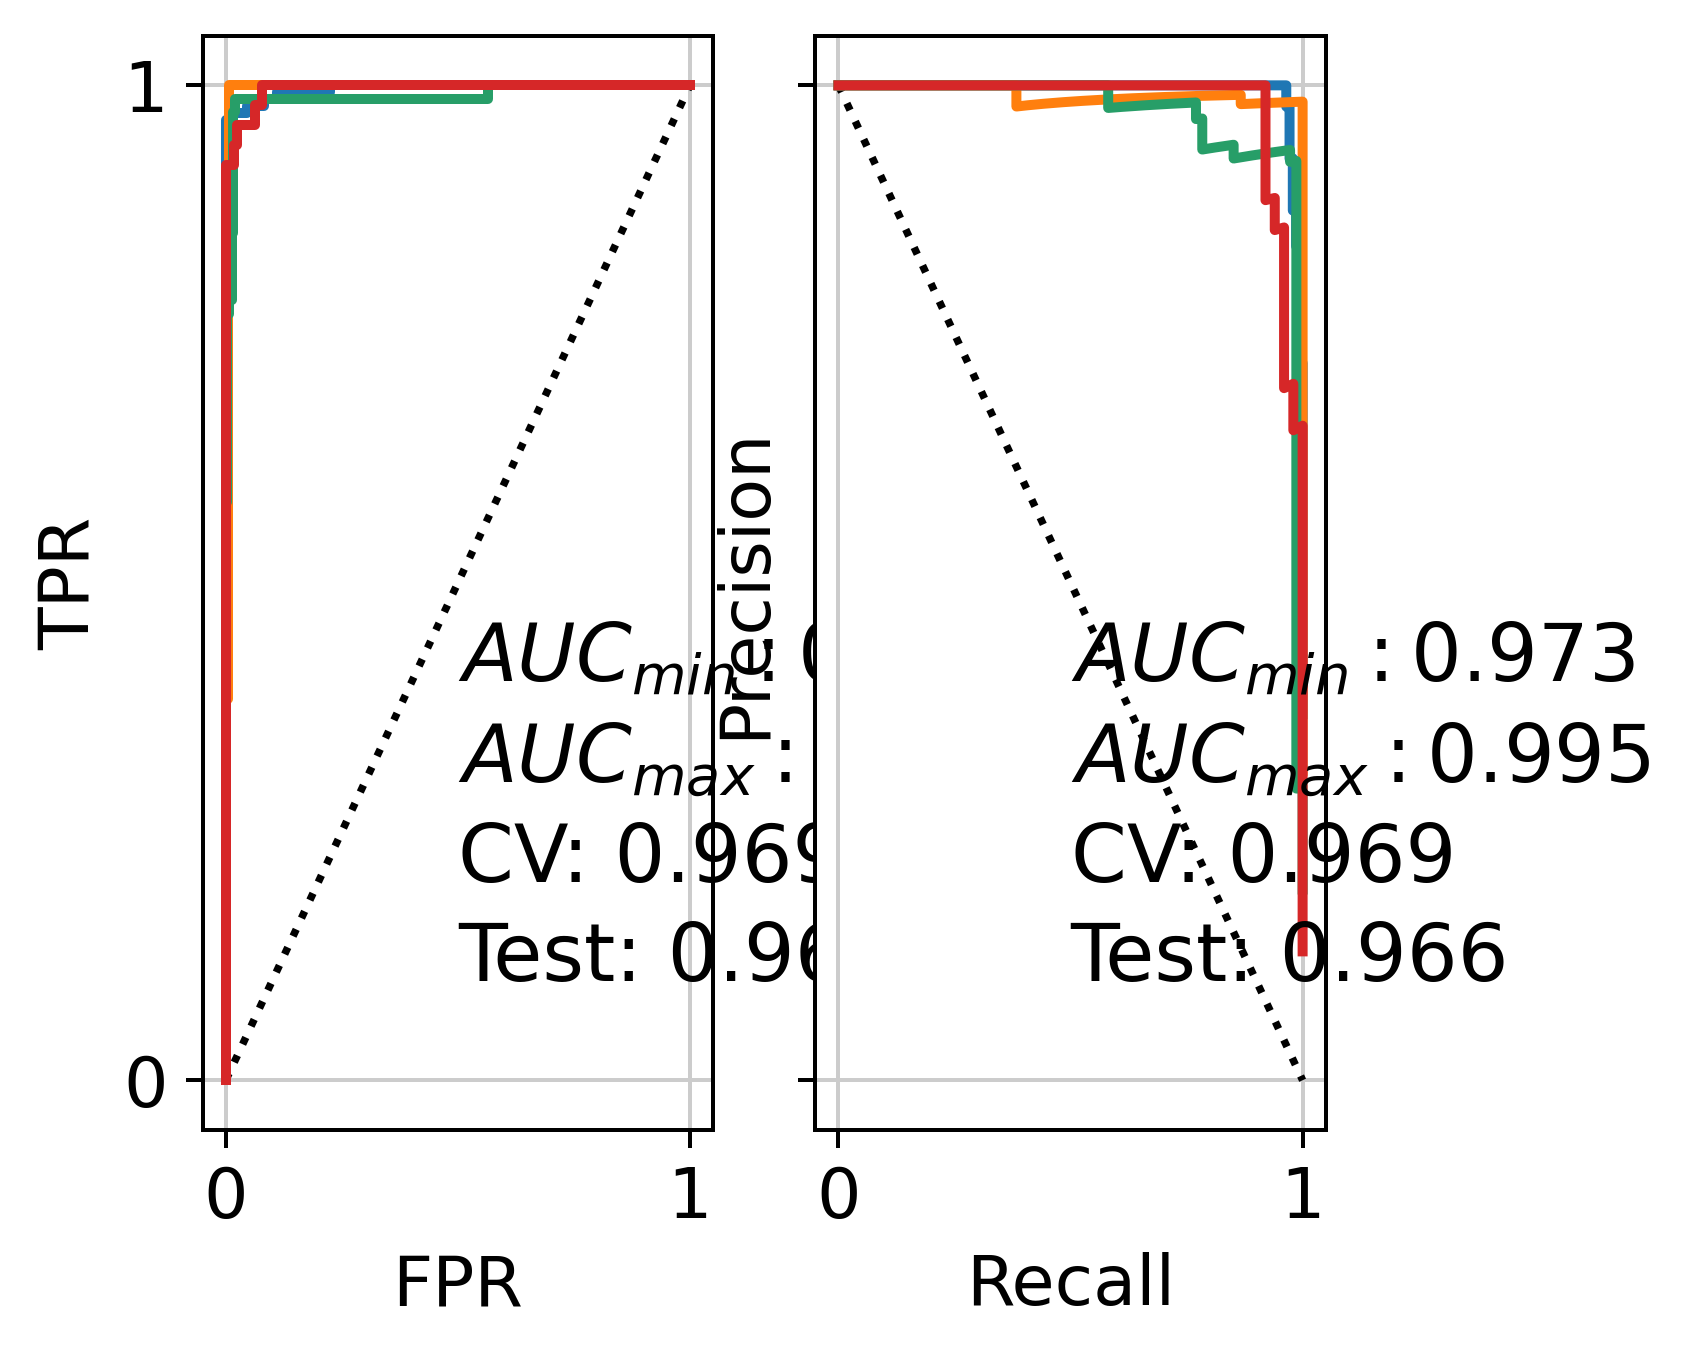

In [16]:
#Plotting code
sc.tl.leiden(adata_Ctr, resolution = 0.1, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata_Ctr.X, adata_Ctr.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.3 and assess with SCCAF

In [17]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Mean CV accuracy: 0.9493
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9467


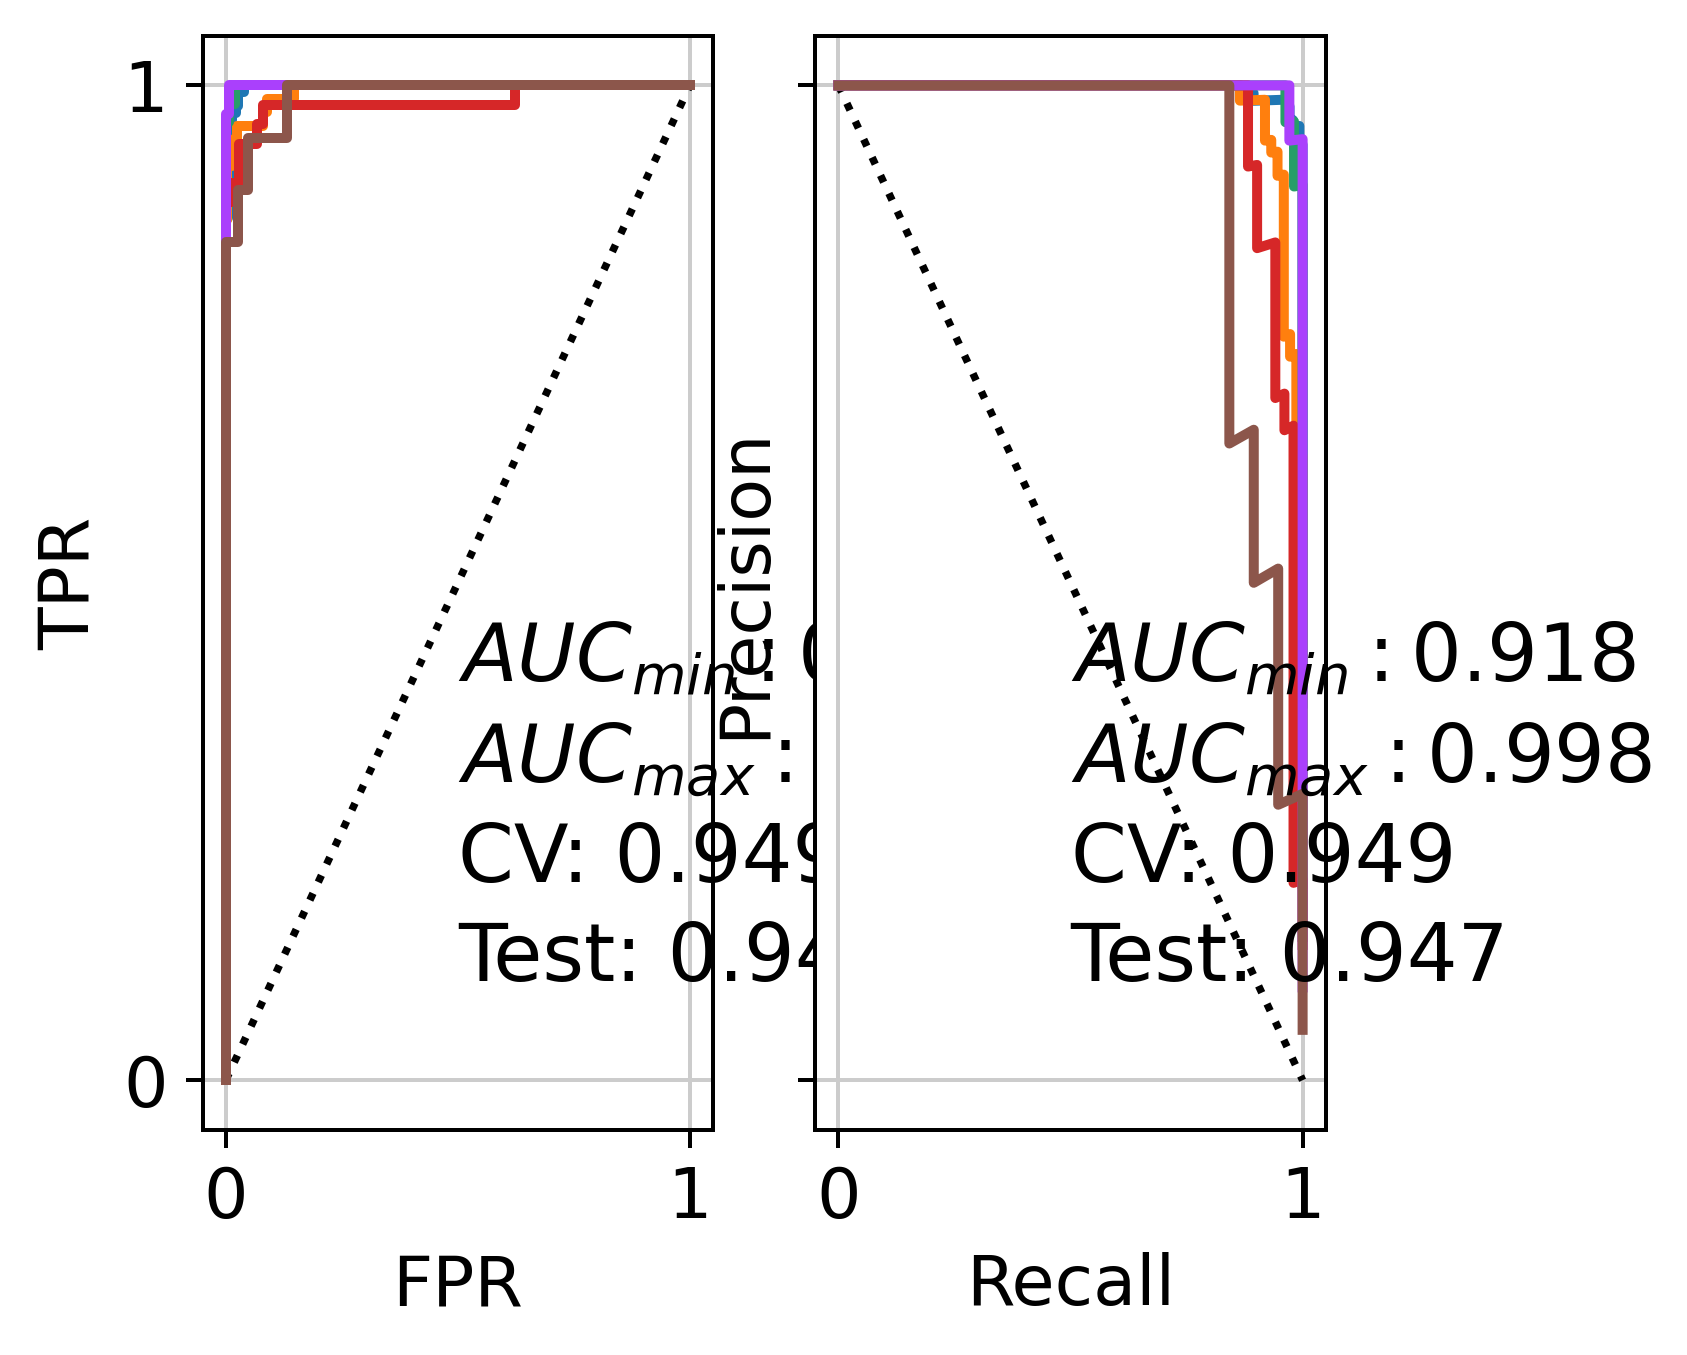

In [18]:
#Plotting code
sc.tl.leiden(adata_Ctr, resolution = 0.3, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata_Ctr.X, adata_Ctr.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.6 and assess with SCCAF

In [19]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Mean CV accuracy: 0.9123
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9270


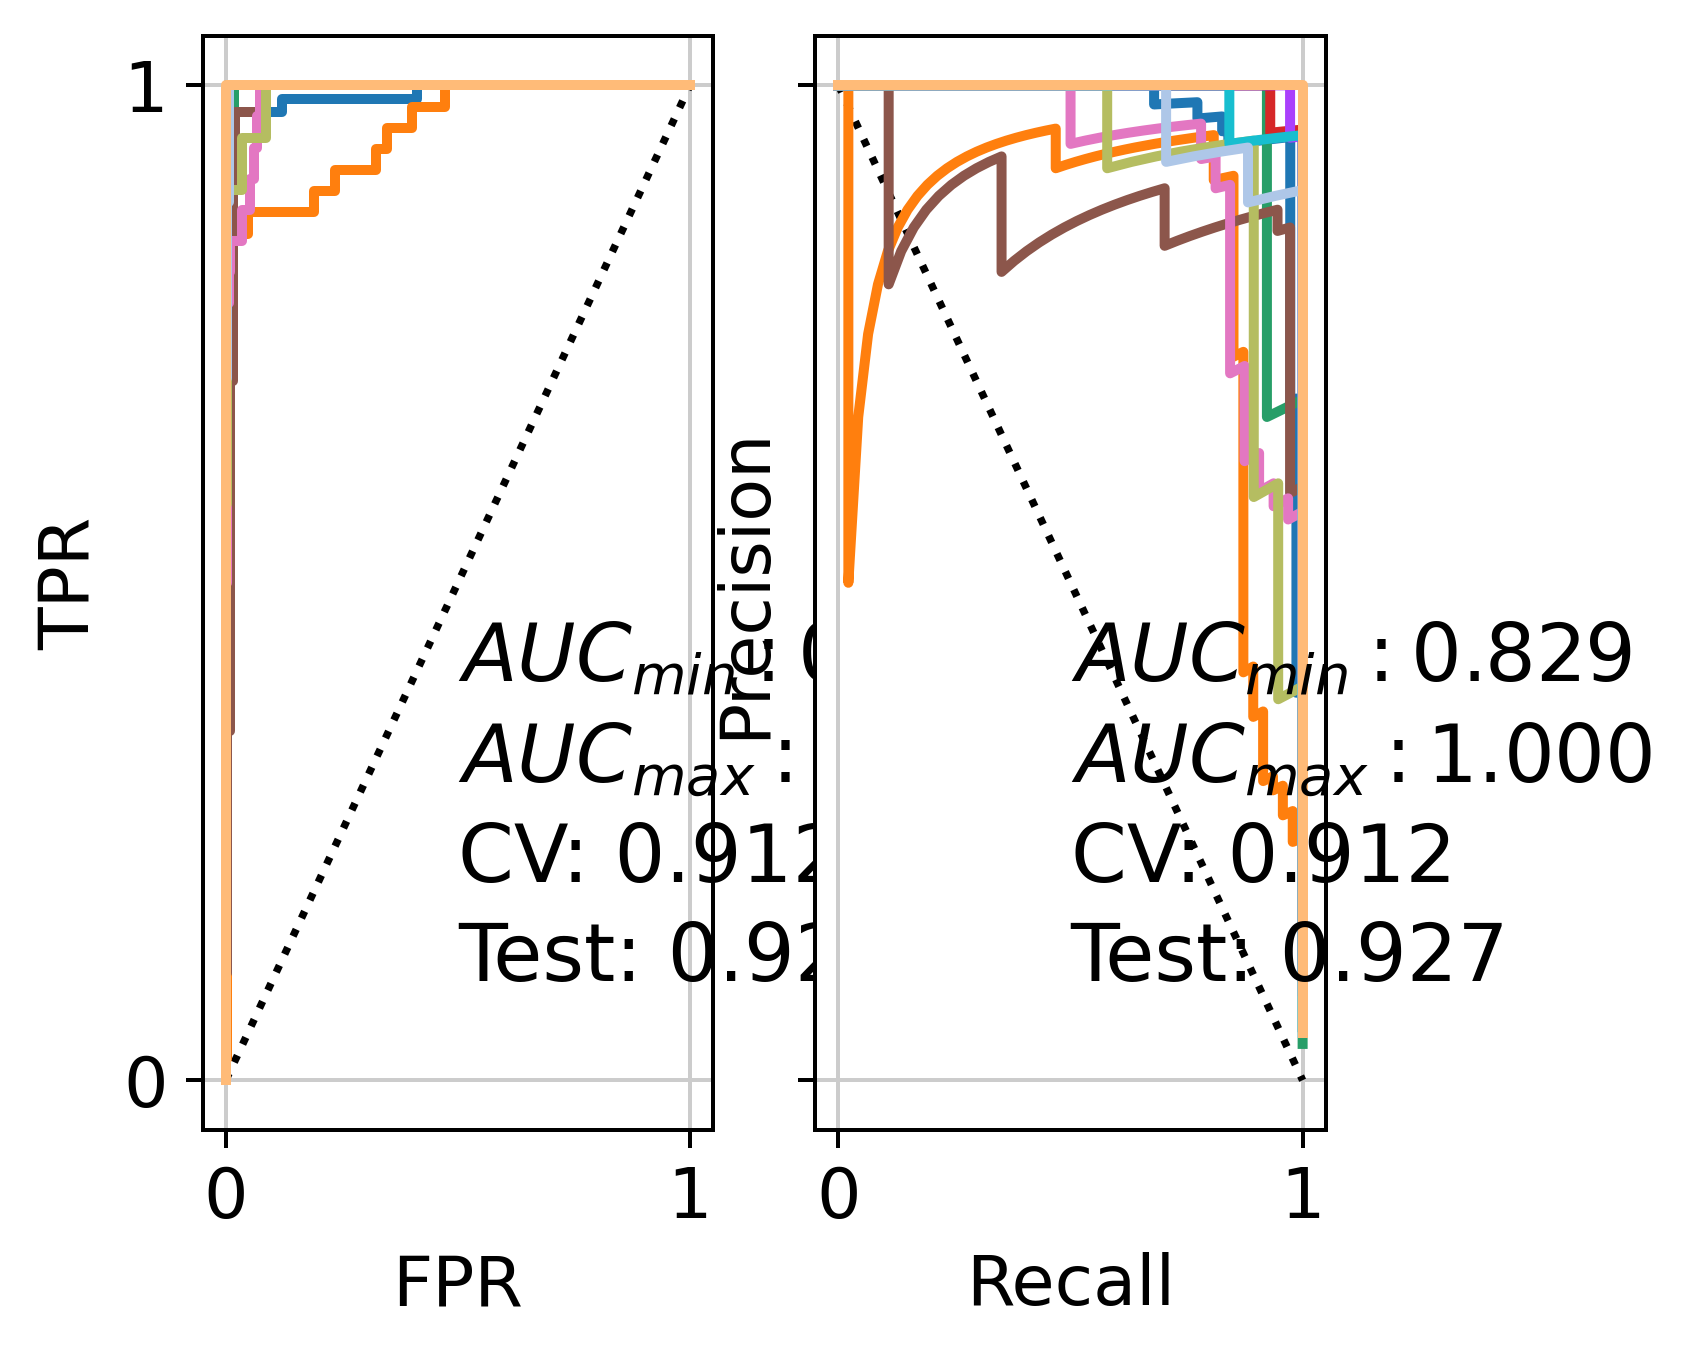

In [20]:
#Plotting code
sc.tl.leiden(adata_Ctr, resolution = 0.6, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata_Ctr.X, adata_Ctr.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.9 and assess with SCCAF

In [21]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Mean CV accuracy: 0.9069
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9242


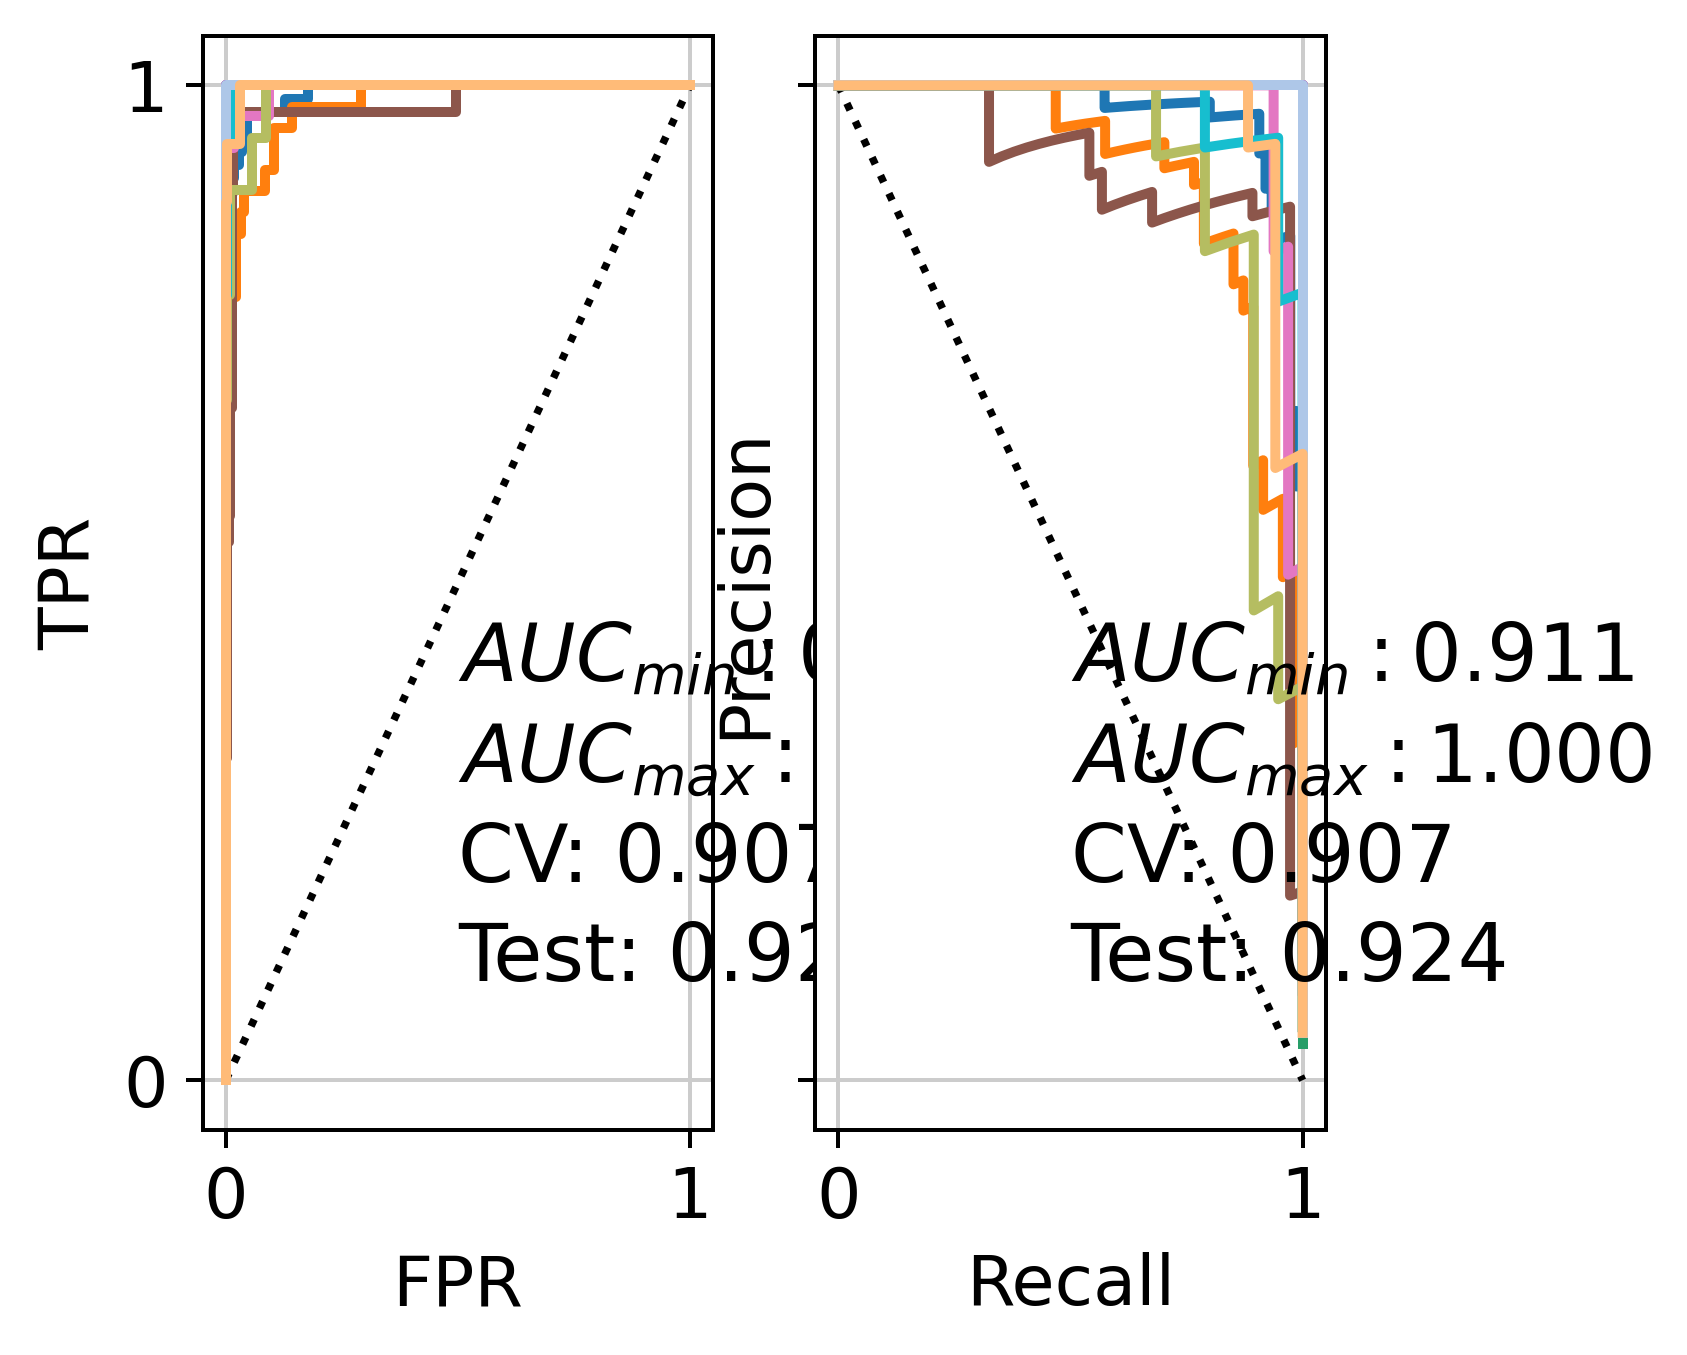

In [22]:
#Plotting code
sc.tl.leiden(adata_Ctr, resolution = 0.9, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata_Ctr.X, adata_Ctr.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 1.2 and assess with SCCAF

In [23]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Mean CV accuracy: 0.8333
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8567


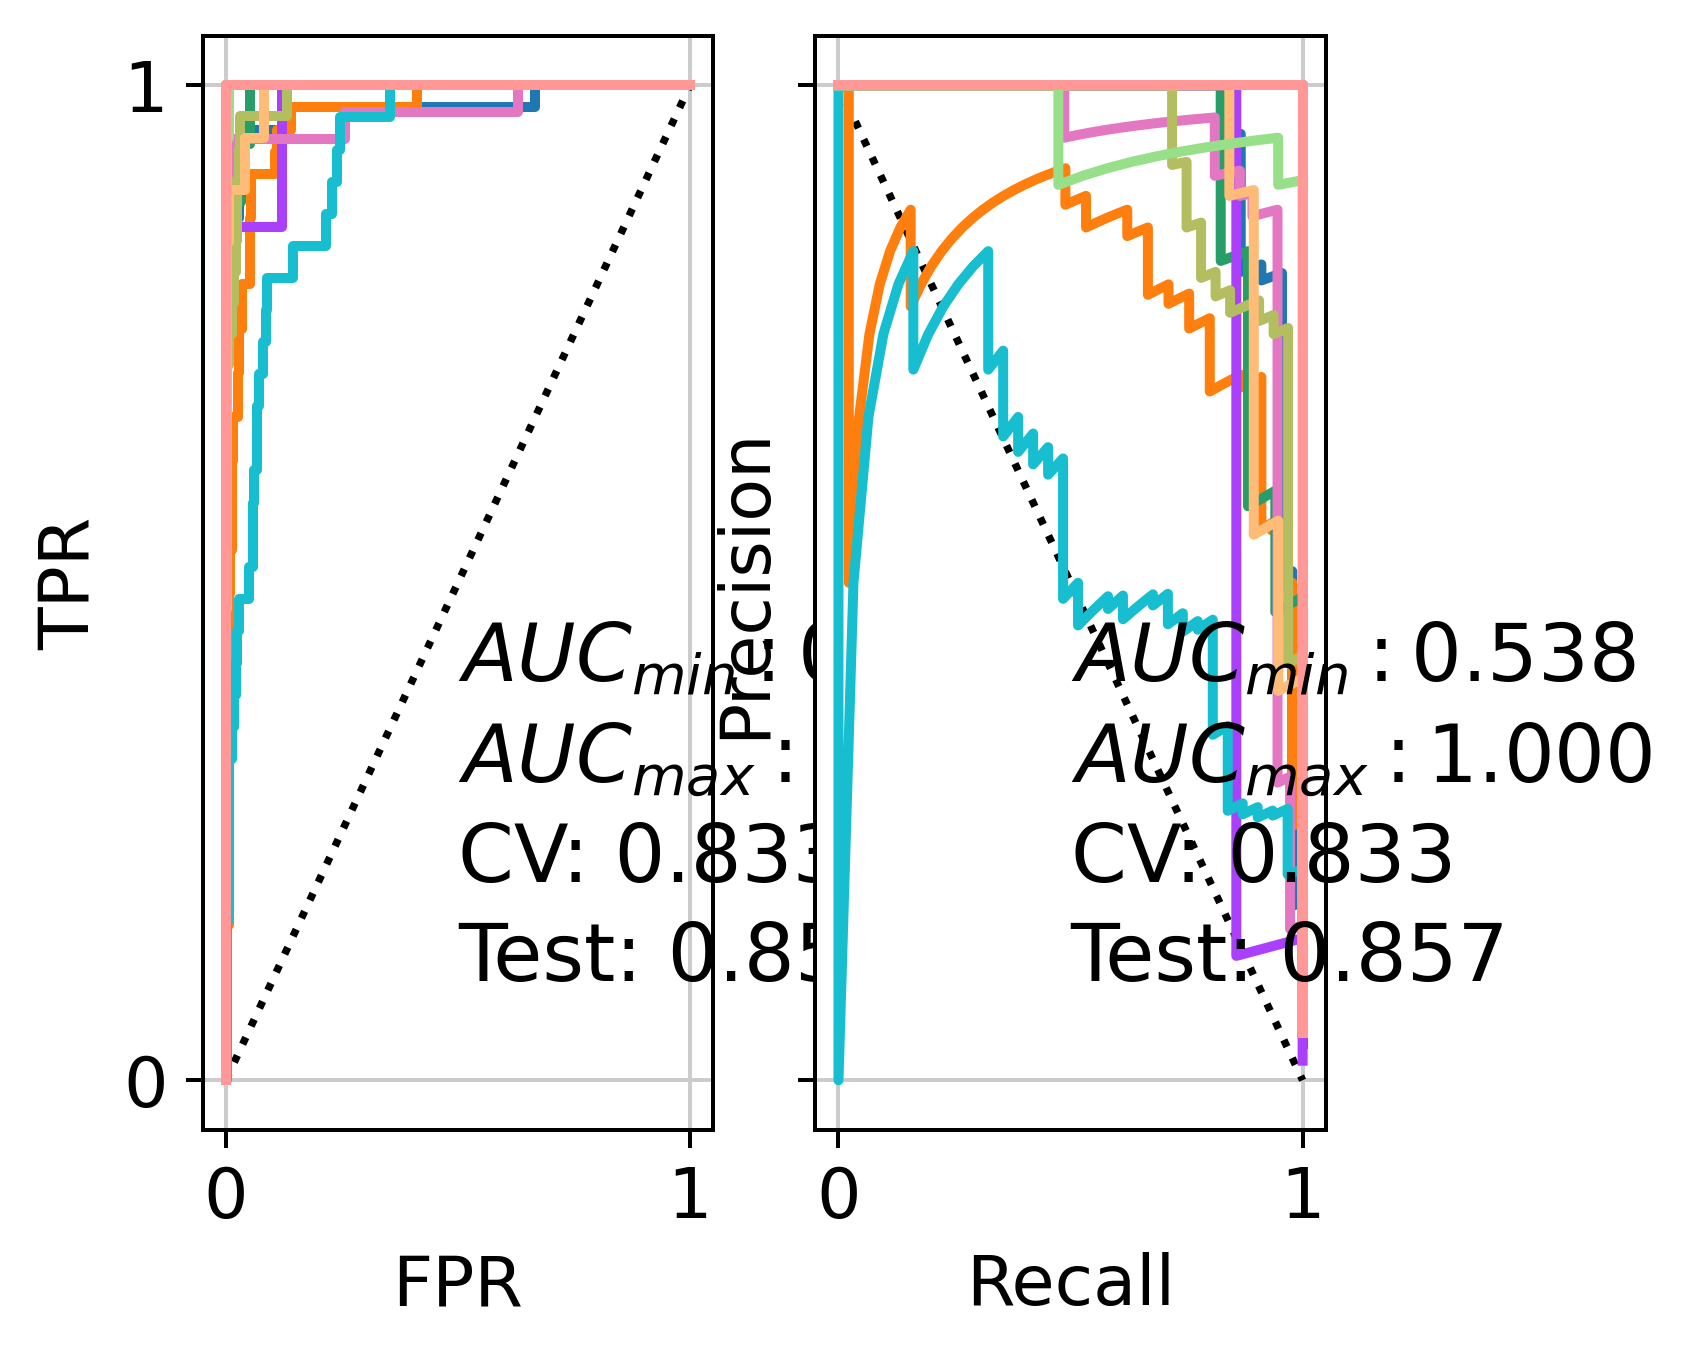

In [24]:
#Plotting code
sc.tl.leiden(adata_Ctr, resolution = 1.2, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata_Ctr.X, adata_Ctr.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 1.5 and assess with SCCAF

In [25]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Mean CV accuracy: 0.7944
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8563


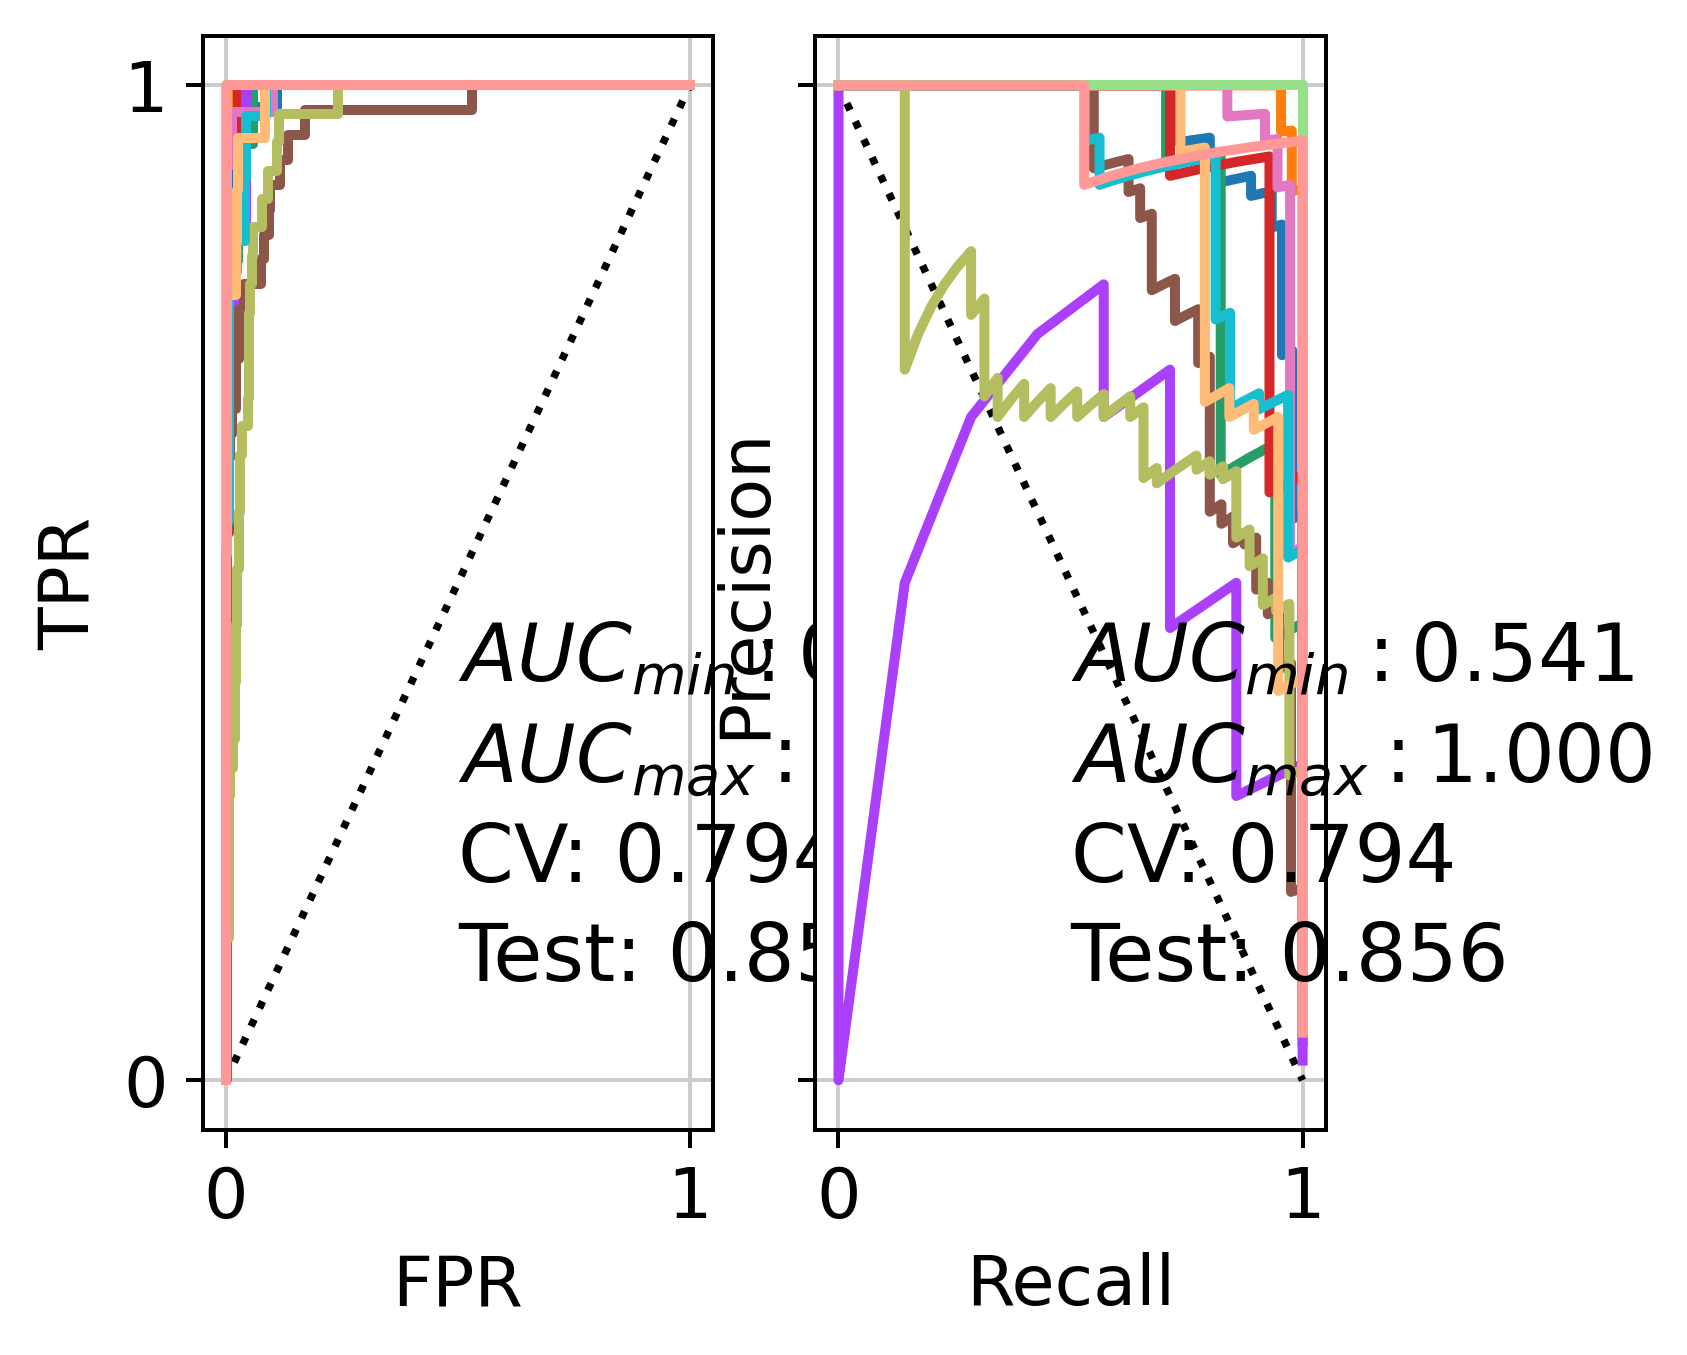

In [26]:
#Plotting code
sc.tl.leiden(adata_Ctr, resolution = 1.5, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata_Ctr.X, adata_Ctr.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

### Choose Resolution for `leiden` clustering
Chosen: 0.9

In [27]:
sc.tl.leiden(adata_Ctr, resolution = 0.6, random_state = 1786)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


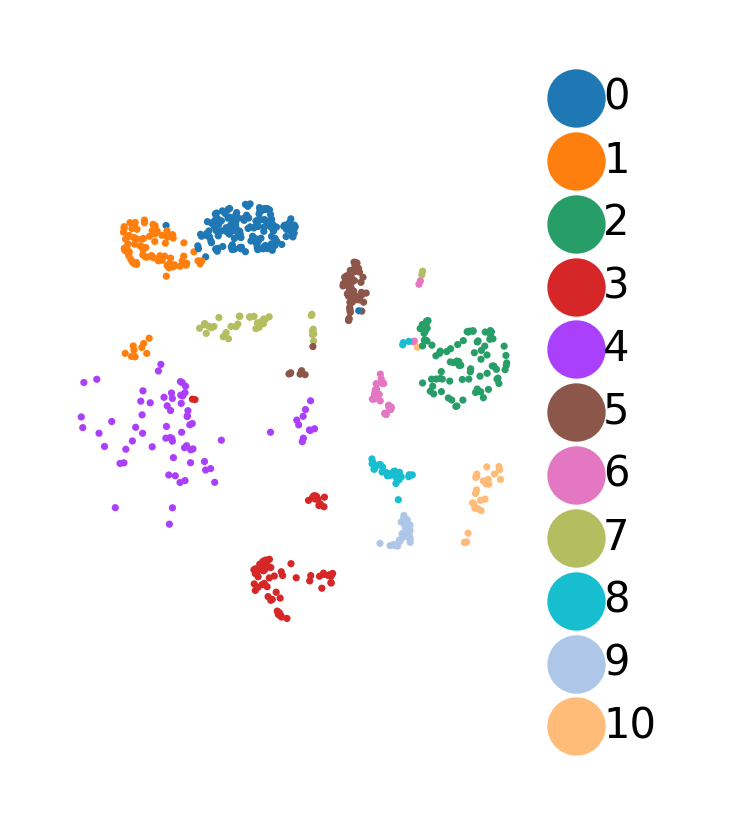

In [28]:
sc.pl.umap(adata_Ctr, color=['leiden'], size = 3, frameon = False, legend_loc="right margin", legend_fontsize= 5, title='')

Save results

In [29]:
#Save the results
adata_Ctr.write_h5ad('/home/acirnu/data/ACM_cardiac_leuco/scANVI/ACM_lymphoids_leiden_clustering_on_Pkp2_Ctr_noninf_ac240325.raw.h5ad')